In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [14]:
# URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0 # YOUR CODE HERE

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [15]:
# URL of the red wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1 

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [16]:
#об'єднуємо в  один датасет
df = pd.concat([red_df, white_df], ignore_index=True)

In [17]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8)]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [18]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 24)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 24)

In [19]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [20]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

# format the output of the train set
y_train = format_output(train)

# format the output of the val set
y_val = format_output(val)
    
# format the output of the test set
y_test = format_output(test)    

In [25]:
def normal(x):
    return (x - train_stats['mean']) / train_stats['std']

# normalize the train set
normal_x_train = normal(train)
    
# normalize the val set
normal_x_val = normal(val)
    
# normalize the test set
normal_x_test = normal(test) 
print(normal_x_train.shape)
print(normal_x_val.shape)

(3155, 11)
(789, 11)


In [28]:
from keras.models import Model
from keras.layers import Dense, Input
def model_first(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
   
    x = Dense(128, activation = 'relu')(inputs)  
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation = 'relu')(x) 
    x = Dense(64, activation = 'relu')(x) 
    x = Dense(32, activation = 'relu')(x) 
    x = Dense(16, activation = 'relu')(x) 
    return x

def final_model(inputs):
    
    # get the base model
    x = model_first(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation= 'sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs= inputs, outputs = [wine_quality, wine_type])

    return model    

In [35]:
inputs = tf.keras.layers.Input(shape=(11,))
model = final_model(inputs)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = {'wine_type' : 'binary_crossentropy'},
              metrics = {'wine_type' : 'accuracy'}
             )

In [36]:
# Train the model
history = model.fit(normal_x_train, y_train, 
                    epochs = 100, batch_size=64, validation_data=(normal_x_val, y_val))

Epoch 1/100


50/50 [==============================] - 2s 13ms/step - loss: 0.6700 - wine_type_loss: 0.6700 - wine_type_accuracy: 0.5819 - val_loss: 0.6196 - val_wine_type_loss: 0.6196 - val_wine_type_accuracy: 0.9265
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 0.5565 - wine_type_loss: 0.5565 - wine_type_accuracy: 0.9655 - val_loss: 0.4624 - val_wine_type_loss: 0.4624 - val_wine_type_accuracy: 0.9861
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.3597 - wine_type_loss: 0.3597 - wine_type_accuracy: 0.9895 - val_loss: 0.2431 - val_wine_type_loss: 0.2431 - val_wine_type_accuracy: 0.9899
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.1618 - wine_type_loss: 0.1618 - wine_type_accuracy: 0.9914 - val_loss: 0.1009 - val_wine_type_loss: 0.1009 - val_wine_type_accuracy: 0.9899
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0719 - wine_type_loss: 0.0719 - wine_type_accuracy: 0.9924 - val_loss: 0.058

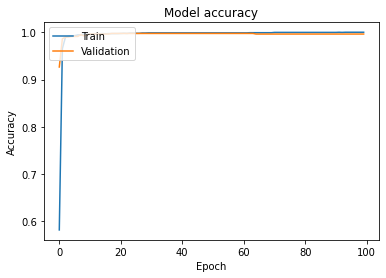

In [37]:
plt.plot(history.history['wine_type_accuracy'])
plt.plot(history.history['val_wine_type_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

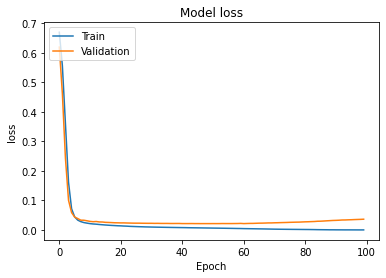

In [38]:
plt.plot(history.history['wine_type_loss'])
plt.plot(history.history['val_wine_type_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
metrics = model.evaluate(normal_x_test, y_test, batch_size=64, verbose=1)
print(metrics)    

16/16 [==============================] - 0s 3ms/step - loss: 0.0453 - wine_type_loss: 0.0453 - wine_type_accuracy: 0.9919
[0.04529581218957901, 0.04529581218957901, 0.9918946027755737]
